In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Basic imports
import os
import glob
import random
import math
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


In [3]:
import os
import glob
import random
import math
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# 1) Load CSV files from archive into a single DataFrame
# --- MODIFICATION START ---
# Assuming archive.zip is in the root of your Google Drive. Adjust the path if it's elsewhere.
root = Path('/content/drive/MyDrive/archive')
# --- MODIFICATION END ---

csv_files = sorted(root.glob('*.csv'))
print(csv_files)
rows = []
for f in csv_files:
    try:
        df = pd.read_csv(f)
    except Exception as e:
        # skip unreadable files
        continue
    # heuristics: look for columns that contain clause text - common names: 'text', 'clause', 'clause_text'
    text_col = None
    for candidate in ['text','clause','clause_text','clauseText','clause_text_1','0']:
        if candidate in df.columns:
            text_col = candidate
            break
    if text_col is None:
        # fallback: take first string-like column
        for c in df.columns:
            if df[c].dtype == object:
                text_col = c
                break
    if text_col is None:
        continue
    for _, r in df.iterrows():
        text = str(r[text_col]) if not pd.isnull(r[text_col]) else ''
        if len(text.strip()) == 0:
            continue
        rows.append({'text': text.strip(), 'category': f.stem})

clauses_df = pd.DataFrame(rows)
print('Loaded clauses:', len(clauses_df))
clauses_df.head()

Device: cuda
[PosixPath('/content/drive/MyDrive/archive/absence-of-certain-changes-or-events.csv'), PosixPath('/content/drive/MyDrive/archive/absence-of-certain-changes.csv'), PosixPath('/content/drive/MyDrive/archive/acceleration.csv'), PosixPath('/content/drive/MyDrive/archive/access-to-information.csv'), PosixPath('/content/drive/MyDrive/archive/access.csv'), PosixPath('/content/drive/MyDrive/archive/accounting-terms.csv'), PosixPath('/content/drive/MyDrive/archive/additional-agreements.csv'), PosixPath('/content/drive/MyDrive/archive/additional-documents.csv'), PosixPath('/content/drive/MyDrive/archive/adjustments.csv'), PosixPath('/content/drive/MyDrive/archive/affirmative-covenants.csv'), PosixPath('/content/drive/MyDrive/archive/agreement.csv'), PosixPath('/content/drive/MyDrive/archive/agreements.csv'), PosixPath('/content/drive/MyDrive/archive/amendment-and-waiver.csv'), PosixPath('/content/drive/MyDrive/archive/amendment-waiver.csv'), PosixPath('/content/drive/MyDrive/archive

,text,category
0,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events
1,Absence of Certain Changes or Events. Since Ma...,absence-of-certain-changes-or-events
2,Absence of Certain Changes or Events. (a) Sinc...,absence-of-certain-changes-or-events
3,Absence of Certain Changes or Events. Since th...,absence-of-certain-changes-or-events
4,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events


In [4]:
# 2) Build pairs: positive = same category, negative = different category
# We'll sample to create a balanced dataset of pairs.
def build_pairs(df, max_pos_per_cat=500, max_neg=20000, seed=42):
    random.seed(seed)
    categories = df['category'].unique().tolist()
    cat_to_texts = {c: df[df['category']==c]['text'].tolist() for c in categories}
    pairs = []
    # positive pairs
    for c, texts in cat_to_texts.items():
        n = len(texts)
        if n < 2:
            continue
        samples = texts if max_pos_per_cat is None else random.sample(texts, min(len(texts), max_pos_per_cat))
        # create random positive pairs from samples
        for i in range(len(samples)):
            for j in range(i+1, len(samples)):
                pairs.append((samples[i], samples[j], 1))
    # negative pairs: sample pairs across categories
    all_texts = df['text'].tolist()
    neg = set()
    attempts = 0
    while len(neg) < max_neg and attempts < max_neg*10:
        a = random.choice(all_texts)
        b = random.choice(all_texts)
        attempts += 1
        # ensure different categories
        if a == b:
            continue
        ca = df[df['text']==a]['category'].iloc[0]
        cb = df[df['text']==b]['category'].iloc[0]
        if ca == cb:
            continue
        neg.add((a,b))
    for a,b in neg:
        pairs.append((a,b,0))
    random.shuffle(pairs)
    return pairs

pairs = build_pairs(clauses_df, max_pos_per_cat=50, max_neg=5000)
print('Total pairs:', len(pairs))


Total pairs: 276853


In [5]:
# 3) Simple tokenizer/vocab builder (whitespace + basic cleanup)
from collections import Counter
import re

def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    toks = text.split()
    return toks

# build vocab
all_text = [t for p in pairs for t in (p[0], p[1])]
counter = Counter()
for t in all_text:
    counter.update(simple_tokenize(t))

# keep top-k words
vocab_size = 20000
most_common = counter.most_common(vocab_size-2)
itos = ['<pad>','<unk>'] + [w for w,_ in most_common]
stoi = {w:i for i,w in enumerate(itos)}

def encode(text, max_len=128):
    toks = simple_tokenize(text)[:max_len]
    ids = [stoi.get(t, 1) for t in toks]
    if len(ids) < max_len:
        ids = ids + [0]*(max_len-len(ids))
    return ids

# quick sanity
print('Vocab size:', len(itos))
print('Example encode:', encode(all_text[0])[:16])


Vocab size: 15985
Example encode: [128, 66, 37, 15, 189, 11, 2, 18, 5, 2, 5524, 9, 10, 76, 20, 9901]


In [6]:
# 4) PyTorch Dataset for pairs
class ClausePairsDataset(Dataset):
    def __init__(self, pairs, max_len=128):
        self.pairs = pairs
        self.max_len = max_len
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        a,b,l = self.pairs[idx]
        a_ids = torch.tensor(encode(a, self.max_len), dtype=torch.long)
        b_ids = torch.tensor(encode(b, self.max_len), dtype=torch.long)
        return a_ids, b_ids, torch.tensor(l, dtype=torch.float)

# split pairs into train/val/test
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.1, random_state=42)

train_ds = ClausePairsDataset(train_pairs)
val_ds = ClausePairsDataset(val_pairs)
test_ds = ClausePairsDataset(test_pairs)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

print(len(train_ds), len(val_ds), len(test_ds))


199333 22149 55371


In [7]:
# 5) Models: Siamese BiLSTM encoder and BiLSTM+Attention encoder
class BiLSTMEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid_dim=128, n_layers=1, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, batch_first=True, bidirectional=True, dropout=dropout if n_layers>1 else 0.0)
        self.pool = nn.AdaptiveAvgPool1d(1)
    def forward(self, x):
        # x: (B, L)
        e = self.emb(x)
        out, _ = self.lstm(e) # (B, L, 2*hid)
        # average pool over sequence length
        out_t = out.transpose(1,2)
        pooled = self.pool(out_t).squeeze(-1)
        return pooled

class AttentionEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid_dim=128, n_layers=1, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, batch_first=True, bidirectional=True, dropout=dropout if n_layers>1 else 0.0)
        self.attn = nn.Linear(hid_dim*2, 1)
    def forward(self, x):
        e = self.emb(x)
        out, _ = self.lstm(e)
        # out: (B, L, 2*hid)
        scores = self.attn(out).squeeze(-1)
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)
        pooled = (out * weights).sum(dim=1)
        return pooled

class SiameseSimilarity(nn.Module):
    def __init__(self, encoder, emb_dim):
        super().__init__()
        self.encoder = encoder
        # classifier on absolute difference and elementwise product
        self.fc = nn.Sequential(
            nn.Linear(emb_dim*2, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128,1)
        )
    def forward(self, a, b):
        ea = self.encoder(a)
        eb = self.encoder(b)
        feat = torch.cat([torch.abs(ea-eb), ea*eb], dim=1)
        out = self.fc(feat).squeeze(-1)
        return out, ea, eb


In [8]:
# 6) Training & evaluation utilities
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    losses = []
    for a,b,l in loader:
        a = a.to(device); b = b.to(device); l = l.to(device)
        optimizer.zero_grad()
        logits,_,_ = model(a,b)
        loss = criterion(logits, l)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ys = []
    ps = []
    for a,b,l in loader:
        a = a.to(device); b = b.to(device)
        logits,_,_ = model(a,b)
        probs = torch.sigmoid(logits).cpu().numpy()
        ys.extend(l.numpy().tolist())
        ps.extend(probs.tolist())
    ys = np.array(ys)
    ps = np.array(ps)
    preds = (ps >= 0.5).astype(int)
    acc = accuracy_score(ys, preds)
    f1 = f1_score(ys, preds)
    try:
        auc = roc_auc_score(ys, ps)
    except Exception:
        auc = float('nan')
    return {'accuracy': acc, 'f1': f1, 'roc_auc': auc}


In [9]:
# 7) Small experiments: train both baselines for a few epochs
vocab_n = len(itos)
emb_dim = 128
hid_dim = 128
epochs = 3

# Baseline A: BiLSTM
encoder_a = BiLSTMEncoder(vocab_n, emb_dim=emb_dim, hid_dim=hid_dim).to(device)
model_a = SiameseSimilarity(encoder_a, emb_dim=hid_dim*2).to(device)
opt_a = torch.optim.Adam(model_a.parameters(), lr=1e-3)
crit = nn.BCEWithLogitsLoss()

for ep in range(epochs):
    loss = train_one_epoch(model_a, train_loader, opt_a, crit)
    val_metrics = evaluate(model_a, val_loader)
    print(f'BiLSTM Ep {ep+1}/{epochs} loss={loss:.4f} val={val_metrics}')

# Baseline B: BiLSTM + Attention
encoder_b = AttentionEncoder(vocab_n, emb_dim=emb_dim, hid_dim=hid_dim).to(device)
model_b = SiameseSimilarity(encoder_b, emb_dim=hid_dim*2).to(device)
opt_b = torch.optim.Adam(model_b.parameters(), lr=1e-3)
for ep in range(epochs):
    loss = train_one_epoch(model_b, train_loader, opt_b, crit)
    val_metrics = evaluate(model_b, val_loader)
    print(f'Attn Ep {ep+1}/{epochs} loss={loss:.4f} val={val_metrics}')

# Final evaluation on test set
print('Final BiLSTM test:', evaluate(model_a, test_loader))
print('Final Attn test:', evaluate(model_b, test_loader))


BiLSTM Ep 1/3 loss=0.0741 val={'accuracy': 0.9973813716194863, 'f1': 0.9986670956473779, 'roc_auc': np.float64(0.9925165247552115)}
BiLSTM Ep 2/3 loss=0.0077 val={'accuracy': 0.9994582148178247, 'f1': 0.999723871324037, 'roc_auc': np.float64(0.9998736265081736)}
BiLSTM Ep 3/3 loss=0.0011 val={'accuracy': 0.9998194049392749, 'f1': 0.9999079571080123, 'roc_auc': np.float64(0.9999540857555648)}
Attn Ep 1/3 loss=0.0695 val={'accuracy': 0.999503363583006, 'f1': 0.9997468529215474, 'roc_auc': np.float64(0.9998276576039236)}
Attn Ep 2/3 loss=0.0070 val={'accuracy': 0.9998645537044561, 'f1': 0.9999309630652399, 'roc_auc': np.float64(0.9999535391574167)}
Attn Ep 3/3 loss=0.0026 val={'accuracy': 0.9999097024696375, 'f1': 0.9999539743176693, 'roc_auc': np.float64(0.9999537577966761)}
Final BiLSTM test: {'accuracy': 0.999909700023478, 'f1': 0.9999540479188302, 'roc_auc': np.float64(0.9999810300021434)}
Final Attn test: {'accuracy': 0.9998735800328692, 'f1': 0.9999356611733564, 'roc_auc': np.float6

## Notes and Next Steps

- This notebook implements two lightweight baselines suitable for quick experiments.
- Limitations: random negative sampling (not hard negatives), small vocab and tokenization; no pre-trained semantic embeddings used (by constraint).
- Improvements: add class-balanced sampling, curriculum/hard-negative mining, better tokenization (subword), and more epochs/hyperparameter search.


In [10]:
# Additional evaluation metrics and plotting (Precision, Recall, PR-AUC)
from sklearn.metrics import precision_score, recall_score, average_precision_score, roc_curve, precision_recall_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import os

def evaluate_full(model, loader):
    model.eval()
    ys = []
    ps = []
    with torch.no_grad():
        for a,b,l in loader:
            a = a.to(device); b = b.to(device)
            logits,_,_ = model(a,b)
            probs = torch.sigmoid(logits).cpu().numpy()
            ys.extend(l.numpy().tolist())
            ps.extend(probs.tolist())
    ys = np.array(ys); ps = np.array(ps)
    preds = (ps >= 0.5).astype(int)
    acc = accuracy_score(ys, preds)
    prec = precision_score(ys, preds, zero_division=0)
    rec = recall_score(ys, preds, zero_division=0)
    f1m = f1_score(ys, preds, zero_division=0)
    try:
        rocauc = roc_auc_score(ys, ps)
    except Exception:
        rocauc = float('nan')
    try:
        pra = average_precision_score(ys, ps)
    except Exception:
        pra = float('nan')
    metrics = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1m, 'roc_auc': rocauc, 'pr_auc': pra}
    return metrics, ys, ps


def plot_roc_pr(ys, ps, title='Model'):
    # ROC
    try:
        fpr, tpr, _ = roc_curve(ys, ps)
        roc_auc = auc(fpr, tpr)
    except Exception:
        fpr, tpr, roc_auc = None, None, float('nan')
    # PR
    try:
        prec, rec, _ = precision_recall_curve(ys, ps)
        pr_auc = auc(rec, prec)
    except Exception:
        prec, rec, pr_auc = None, None, float('nan')

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    if fpr is not None:
        plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC - {title}'); plt.legend()

    plt.subplot(1,2,2)
    if rec is not None:
        plt.plot(rec, prec, label=f'PR AUC={pr_auc:.3f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'PR - {title}'); plt.legend()

    plt.tight_layout()
    display(plt.show())


Starting training for BiLSTM...
bilstm Ep1/5 loss=0.0006 val={'accuracy': 0.9998194049392749, 'precision': 0.999815939628198, 'recall': 1.0, 'f1': 0.9999079613437644, 'roc_auc': np.float64(1.0), 'pr_auc': np.float64(1.0)}
bilstm Ep2/5 loss=0.0002 val={'accuracy': 0.9991421734615559, 'precision': 0.999126316273509, 'recall': 1.0, 'f1': 0.9995629672225417, 'roc_auc': np.float64(0.999996665751297), 'pr_auc': np.float64(0.9999999343331682)}
bilstm Ep3/5 loss=0.0003 val={'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': np.float64(1.0), 'pr_auc': np.float64(1.0)}
bilstm Ep4/5 loss=0.0001 val={'accuracy': 0.9993679172874622, 'precision': 0.9993560849967804, 'recall': 1.0, 'f1': 0.9996779388083736, 'roc_auc': np.float64(0.9988108757289432), 'pr_auc': np.float64(0.999953936187029)}
bilstm Ep5/5 loss=0.0001 val={'accuracy': 0.9999548512348188, 'precision': 0.9999539785540061, 'recall': 1.0, 'f1': 0.9999769887474975, 'roc_auc': np.float64(1.0), 'pr_auc': np.float64(1.0)}
bi

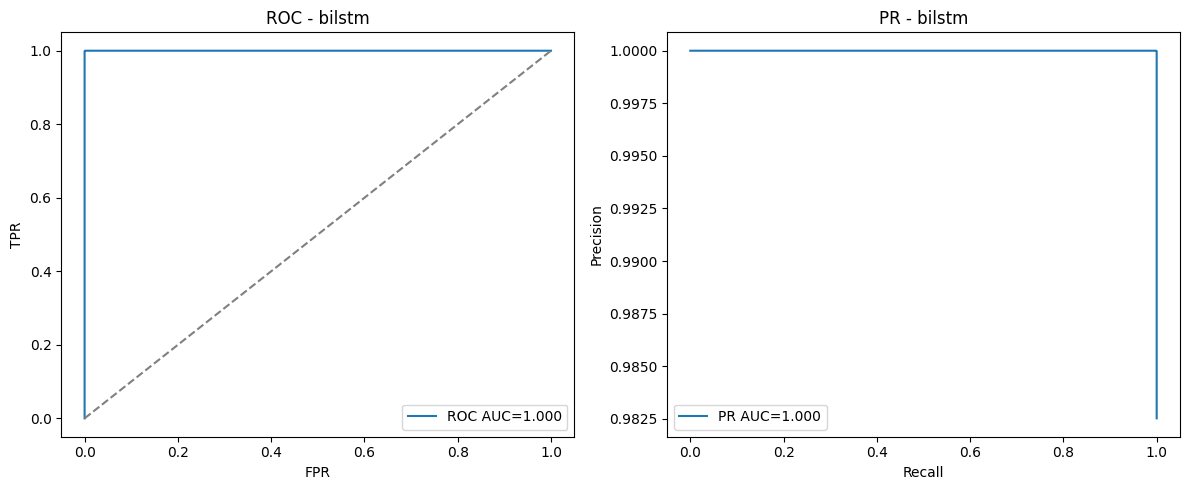

None


Starting training for Attention encoder...
attn Ep1/5 loss=0.0016 val={'accuracy': 0.9998645537044561, 'precision': 0.9999539743176693, 'recall': 0.9999079528718704, 'f1': 0.9999309630652399, 'roc_auc': np.float64(0.9999533205181576), 'pr_auc': np.float64(0.9999982504022329)}
attn Ep2/5 loss=0.0012 val={'accuracy': 0.9999097024696375, 'precision': 1.0, 'recall': 0.9999079528718704, 'f1': 0.9999539743176693, 'roc_auc': np.float64(0.9999538671163055), 'pr_auc': np.float64(0.9999982504022329)}
attn Ep3/5 loss=0.0011 val={'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': np.float64(1.0), 'pr_auc': np.float64(1.0)}
attn Ep4/5 loss=0.0000 val={'accuracy': 0.9999548512348188, 'precision': 0.9999539785540061, 'recall': 1.0, 'f1': 0.9999769887474975, 'roc_auc': np.float64(1.0), 'pr_auc': np.float64(1.0)}
attn Ep5/5 loss=0.0005 val={'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': np.float64(1.0), 'pr_auc': np.float64(1.0)}
attn Test: {'accuracy': 0.

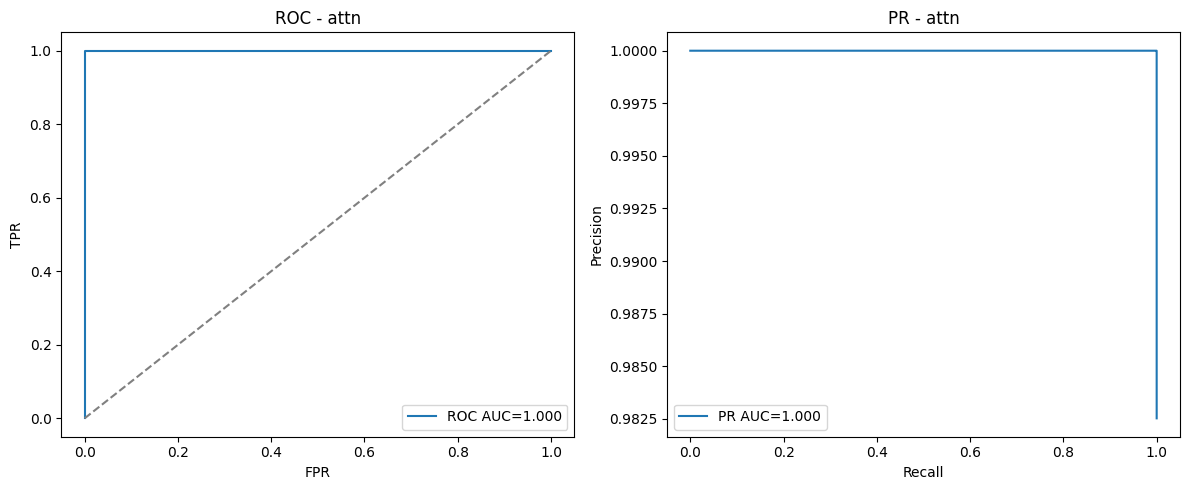

None

,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,bilstm,0.999946,0.999945,1.0,0.999972,0.999999,1.0
1,attn,0.999982,0.999982,1.0,0.999991,1.000000,1.0


In [11]:
# Training wrapper that logs per-epoch metrics and saves results
from pathlib import Path

def train_and_log(model, train_loader, val_loader, test_loader, epochs=5, lr=1e-3, name='model'):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.BCEWithLogitsLoss()
    rows = []
    for ep in range(1, epochs+1):
        train_loss = train_one_epoch(model, train_loader, opt, crit)
        val_metrics, _, _ = evaluate_full(model, val_loader)
        print(f"{name} Ep{ep}/{epochs} loss={train_loss:.4f} val={val_metrics}")
        row = {'epoch': ep, 'train_loss': train_loss}
        for k,v in val_metrics.items():
            row[f'val_{k}'] = v
        rows.append(row)
    # final test
    test_metrics, ys, ps = evaluate_full(model, test_loader)
    print(f"{name} Test: {test_metrics}")
    df = pd.DataFrame(rows)
    out_dir = Path('outputs')
    out_dir.mkdir(exist_ok=True)
    df.to_csv(out_dir / f'{name}_metrics_per_epoch.csv', index=False)
    np.save(out_dir / f'{name}_test_ys.npy', ys)
    np.save(out_dir / f'{name}_test_ps.npy', ps)
    # plot ROC/PR
    plot_roc_pr(ys, ps, title=name)
    return df, test_metrics

# Run training for both models and save logs (set epochs reasonably; adjust as needed)
epochs_run = 5
print('Starting training for BiLSTM...')
df_a, test_a = train_and_log(model_a, train_loader, val_loader, test_loader, epochs=epochs_run, lr=1e-3, name='bilstm')
print('\nStarting training for Attention encoder...')
df_b, test_b = train_and_log(model_b, train_loader, val_loader, test_loader, epochs=epochs_run, lr=1e-3, name='attn')

# show a summary table
summary = pd.DataFrame([{'model':'bilstm', **test_a}, {'model':'attn', **test_b}])
summary
